![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Value at Risk

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/iwh-halle/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/iwh-halle/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

### Task: 

Load the data and show in a single plot the cumulative log-returns of '.GDAXI' as well as an equally weighted portfolio of its constituents (all the other assets in 02_python_data.csv, excluding '.GDAXI').

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the data
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
logreturns = np.log(prices) - np.log(prices.shift(1))

In [12]:
# Calculating the mean per column for the equal weighted portfolio
eq_wei_portfolio_log = pd.DataFrame(logreturns.iloc[:,1:].mean(axis=1), index=logreturns.index)
eq_wei_portfolio_log.columns = ['Equal Weighted Portfolio']
# display(eq_wei_portfolio)

# extracting the values for gedaxi_log_ret
gedaxi_log_ret = pd.DataFrame(logreturns['.GDAXI'])
# display(gedaxi_log_ret)

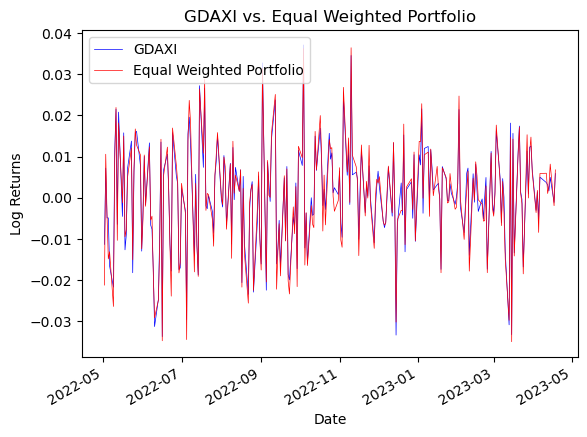

In [44]:
gedaxi_log_ret['.GDAXI'].plot(linewidth=0.5, color='blue', label='GDAXI')
eq_wei_portfolio_log['Equal Weighted Portfolio'].plot(linewidth=0.5, color='red', label='Equal Weighted Portfolio')
plt.legend(loc='upper left')
plt.title('GDAXI vs. Equal Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.savefig('04_var_Log_Returns.png')
plt.show()

### Task: 

We now want to compare the risk of **both** portfolios from the previous task ('.GDAXI and the equally weighted portfolio'). To do so, calculate the 95% 1-day [Value at Risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk), using:

* Historical simulation,
* the Parametric method,
* Monte Carlo simulation.

Add all values to a data frame and `display()`

In [14]:
# Loading returns data
returns = prices.pct_change()

# removing nan values
returns = returns.iloc[1:,:]

# Extrating the values for gedaxi
gdaxi_ret = pd.DataFrame(returns['.GDAXI'])

# Calculating the mean per column for the equal weighted portfolio
eq_wei_portfolio_ret = pd.DataFrame(returns.iloc[:,1:].mean(axis=1), index=logreturns.index)
eq_wei_portfolio_ret.columns = ['Equal Weighted Portfolio']

# removing nan values
eq_wei_portfolio_ret = eq_wei_portfolio_ret.iloc[1:,:]

In [15]:
# Historical VaR
# setting the confidence level
confidence_level = 0.95

# Calculating the VaR for the GDAXI and the equal weighted portfolio
hist_sim_GDAXI = np.percentile(gdaxi_ret['.GDAXI'].dropna(), 100 * (1 - confidence_level))
hist_sim_eq_wei_port = np.percentile(eq_wei_portfolio_ret['Equal Weighted Portfolio'].dropna(), 100 * (1 - confidence_level))

# Creating result DataFrame
compar_df = pd.DataFrame({'Historical Simulation': [hist_sim_GDAXI, hist_sim_eq_wei_port]}, index=['.GDAXI', 'Equal Weighted Portfolio'])
# compar_df

In [16]:
from scipy import stats
# Parametric VaR
alpha = stats.norm.ppf(confidence_level)

# Calculating the mean and the covariance matrix for GDAXI
mean_returns_GDAXI = returns['.GDAXI'].mean()
std_returns_GDAXI = returns['.GDAXI'].std()

# Calculating the parametric VaR for GDAXI
VaR_1day_95_param_GDAXI = -mean_returns_GDAXI - alpha * std_returns_GDAXI



# Calculating the mean and the covariance matrix for the equal weighted portfolio
mean_returns_port = eq_wei_portfolio_ret['Equal Weighted Portfolio'].mean()
std_returns_port = eq_wei_portfolio_ret['Equal Weighted Portfolio'].std()

# Calculating the parametric VaR for the equal weighted portfolio
VaR_1day_95_param_port = -mean_returns_port - alpha * std_returns_port



# Adding to the result DataFrame
compar_df['Parametric'] = [VaR_1day_95_param_GDAXI, VaR_1day_95_param_port]  
# compar_df

In [17]:
# Monte Carlo VaR
np.random.seed(888) # setting a seed for reproducibility
n_sim = 10000

# Simulate daily returns for GDAXI
sim_returns_GDAXI = np.random.normal(mean_returns_GDAXI, std_returns_GDAXI, n_sim)

VaR_1day_95_sim_GDAXI = np.percentile(sim_returns_GDAXI, 100 * (1 - confidence_level))


# Simulate daily returns for the equal weighted portfolio
sim_returns_port = np.random.normal(mean_returns_port, std_returns_port, n_sim)

VaR_1day_95_sim_port = np.percentile(sim_returns_port, 100 * (1 - confidence_level))


# Adding to the result DataFrame
compar_df['Monte Carlo'] = [VaR_1day_95_sim_GDAXI, VaR_1day_95_sim_port]  
display(compar_df)

,Historical Simulation,Parametric,Monte Carlo
.GDAXI,-0.019268,-0.020433,-0.019054
Equal Weighted Portfolio,-0.021563,-0.021616,-0.020645


### Task: 

In order to visualize the VaR results we focus only on '.GDAXI' (you can create `plt.subplots()` for the equally weighted portfolio if you like). In the plot:

1. Plot a histogram of the returns
2. Add a line plot of the normal distribution (parameterized to the returns)
3. Add indicators for the 3 VaRs (vertical lines or annotations)

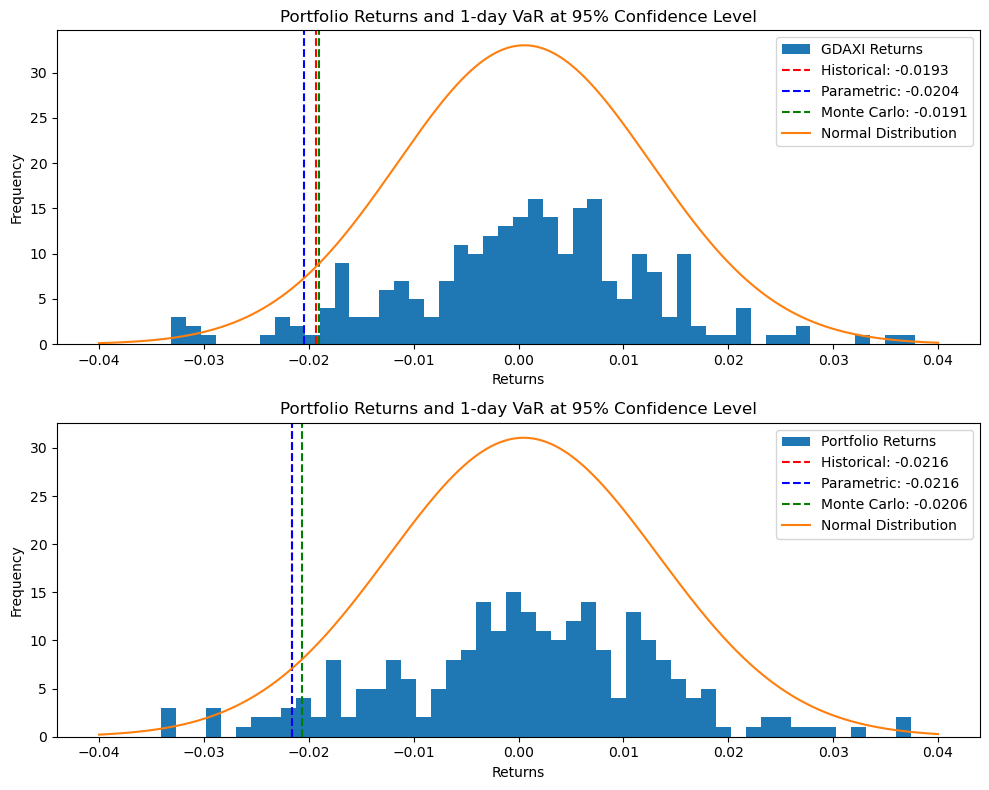

In [42]:
from scipy.stats import norm

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot GDAXI
axs[0].hist(gdaxi_ret['.GDAXI'],bins=50, label='GDAXI Returns')
axs[0].axvline(x=compar_df.at['.GDAXI','Historical Simulation'], color='red', linestyle='--', label=f"Historical: {compar_df.at['.GDAXI','Historical Simulation']:.4f}")
axs[0].axvline(x=compar_df.at['.GDAXI','Parametric'], color='blue', linestyle='--', label=f"Parametric: {compar_df.at['.GDAXI','Parametric']:.4f}")
axs[0].axvline(x=compar_df.at['.GDAXI','Monte Carlo'], color='green', linestyle='--', label=f"Monte Carlo: {compar_df.at['.GDAXI','Monte Carlo']:.4f}")
axs[0].set_xlabel('Returns')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Portfolio Returns and 1-day VaR at 95% Confidence Level')


# Create x values for the normal distribution
x0 = np.linspace(-0.04, 0.04, 1000)
# Create the normal distribution
norm_distribution = norm(mean_returns_GDAXI, std_returns_GDAXI)
# Calculate the y values for the normal distribution
y0 = norm_distribution.pdf(x0)

# Plot the normal distribution
axs[0].plot(x0, y0, label='Normal Distribution')
axs[0].legend()

axs[1].hist(eq_wei_portfolio_ret['Equal Weighted Portfolio'], bins=50, label='Portfolio Returns')
axs[1].axvline(x=compar_df.at['Equal Weighted Portfolio','Historical Simulation'], color='red', linestyle='--', label=f"Historical: {compar_df.at['Equal Weighted Portfolio','Historical Simulation']:.4f}")
axs[1].axvline(x=compar_df.at['Equal Weighted Portfolio','Parametric'], color='blue', linestyle='--', label=f"Parametric: {compar_df.at['Equal Weighted Portfolio','Parametric']:.4f}")
axs[1].axvline(x=compar_df.at['Equal Weighted Portfolio','Monte Carlo'], color='green', linestyle='--', label=f"Monte Carlo: {compar_df.at['Equal Weighted Portfolio','Monte Carlo']:.4f}")
axs[1].set_xlabel('Returns')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Portfolio Returns and 1-day VaR at 95% Confidence Level')


# Create x values for the normal distribution
x1 = np.linspace(-0.04, 0.04, 1000)
# Create the normal distribution
norm_distribution = norm(mean_returns_port, std_returns_port)
# Calculate the y values for the normal distribution
y1 = norm_distribution.pdf(x1)

# Plot the normal distribution
axs[1].plot(x1, y1, label='Normal Distribution')

axs[1].legend()
plt.tight_layout()
plt.savefig('04_var_1_day_VaR_95.png')
plt.show()

